<a href="https://colab.research.google.com/github/BrouthenKamel/HAICK-2023/blob/main/Sonatrach_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras as keras
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import seaborn as sns

In [35]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [36]:
data_path = '/gdrive/MyDrive/Sonatrach_Dataset'

In [37]:
data_sample = pd.read_csv(data_path+'/sample.csv')
data_train = pd.read_csv(data_path+'/train_dataset.csv')
data_test = pd.read_csv(data_path+'/test_dataset.csv')

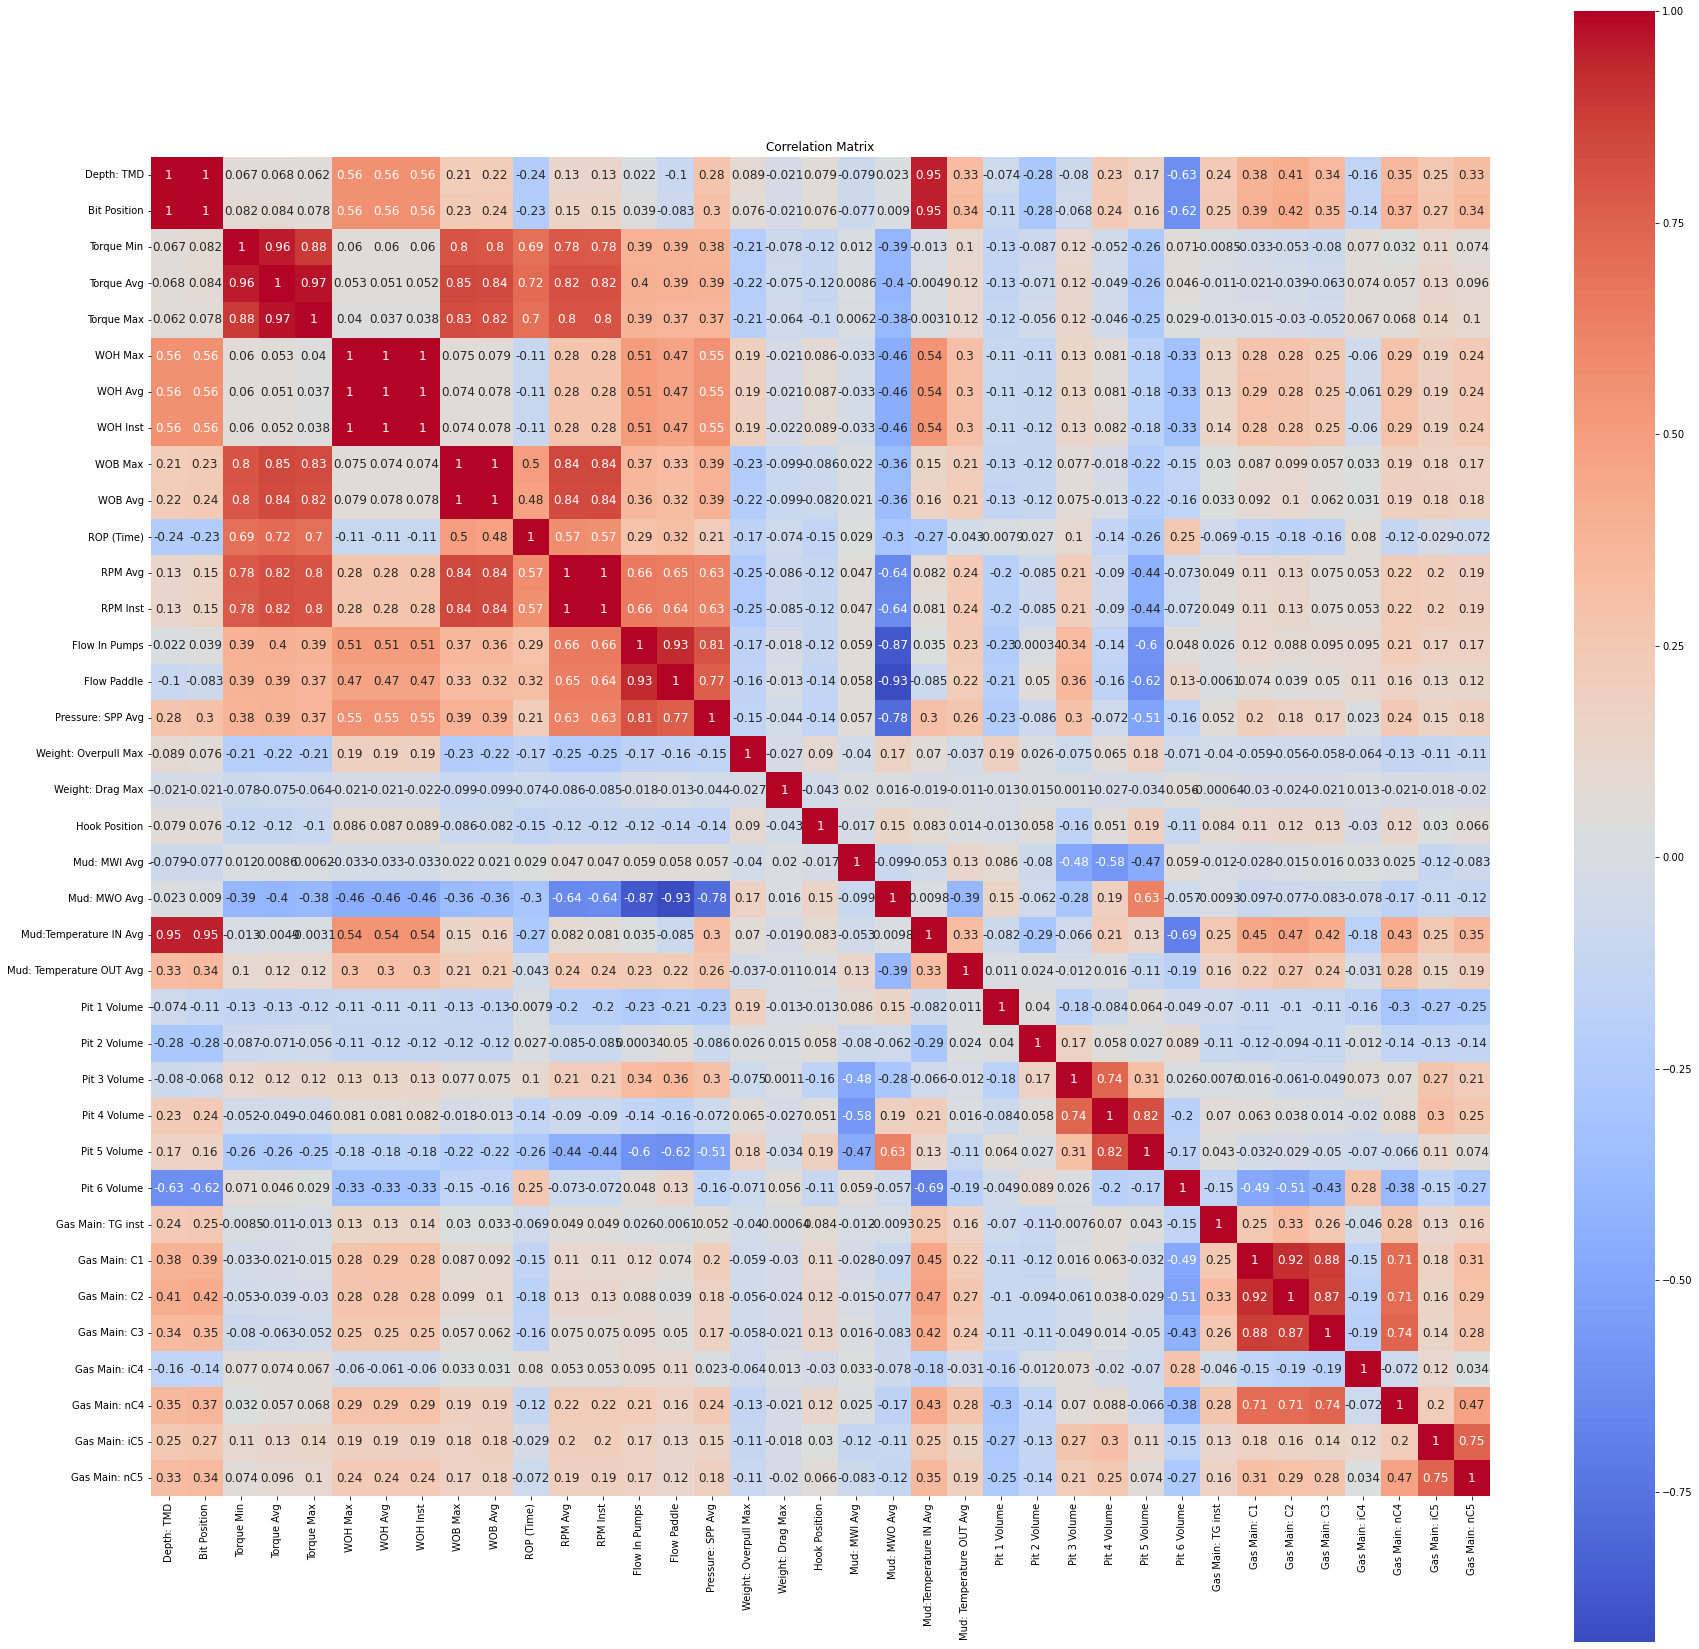

In [38]:
corr = data_train.corr()

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corr, cmap='coolwarm', annot=True, annot_kws={'size': 12}, square=True)

plt.title('Correlation Matrix')
plt.show()

In [39]:
#drop_cols = [ "Bit Position", "Torque Min", "Torque Max", "WOH Inst", "WOH Max", "WOB Max", "RPM Inst", "Gas Main: C1", "Gas Main: C3"]

In [40]:
#data_train.drop(columns = drop_cols, inplace = True)
#data_test.drop(columns = drop_cols, inplace = True)

In [41]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [42]:
mi_scores = make_mi_scores(data_train.drop(columns = ["ROP (Time)"]), data_train["ROP (Time)"])
mi_scores

Depth: TMD                  3.119993
Bit Position                2.639687
Gas Main: C1                1.236843
Flow In Pumps               1.117065
RPM Avg                     1.076115
Pressure: SPP Avg           0.984870
Mud:Temperature IN Avg      0.983941
Pit 2 Volume                0.919247
RPM Inst                    0.911620
WOB Avg                     0.896558
WOB Max                     0.875957
Hook Position               0.850225
Pit 5 Volume                0.827675
Gas Main: C2                0.806907
Pit 6 Volume                0.794615
WOH Avg                     0.730394
WOH Max                     0.724698
Gas Main: nC4               0.723949
Pit 3 Volume                0.719557
Pit 4 Volume                0.715903
Torque Max                  0.710379
Torque Avg                  0.675321
WOH Inst                    0.673778
Torque Min                  0.662694
Mud: Temperature OUT Avg    0.645076
Gas Main: C3                0.617312
Gas Main: iC5               0.594099
G

In [43]:
X = data_train.drop(columns = ["ROP (Time)"])
y = data_train["ROP (Time)"]

In [44]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_standardized = pd.DataFrame(X_standardized, columns=data_train.drop(columns = ["ROP (Time)"]).columns)

In [45]:
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_standardized)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,5.761816,-2.503586,0.082445,1.109747,-2.498940,0.197451,1.267715,-0.179587,-0.705152,0.410927,...,-0.146397,-0.021754,-0.506985,0.241559,0.918510,0.162330,0.561252,-0.590410,-0.488346,0.318559
1,5.688759,-2.549047,-0.008387,1.107061,-2.529669,0.209672,1.285583,-0.142858,-0.717039,0.421388,...,-0.096702,-0.037665,-0.512749,0.269673,0.965225,0.159827,0.624168,-0.609285,-0.508186,0.301877
2,5.785639,-2.508448,0.069646,1.205118,-2.467734,0.137754,1.254297,-0.160977,-0.717796,0.392223,...,-0.308470,-0.055265,-0.484436,0.213117,0.890046,0.158270,0.551071,-0.548606,-0.471599,0.319178
3,5.759341,-2.522675,0.036974,1.206588,-2.474869,0.136152,1.254821,-0.131316,-0.724474,0.398807,...,-0.351706,-0.077344,-0.472904,0.220540,0.916495,0.170114,0.589656,-0.597222,-0.481654,0.319712
4,5.813274,-2.440876,0.241392,0.865381,-2.553367,0.346314,1.298457,-0.333341,-0.661657,0.412831,...,0.267152,0.100973,-0.589734,0.268322,0.895075,0.136298,0.451415,-0.514898,-0.492649,0.308155


In [46]:
X_pca.shape

(72000, 25)

In [47]:
'''from keras.engine.training import Model


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

param_grid = {'alpha' : [0.02, 0.01, 0.05],
              'penalty' : ['l1', 'l2'],
              }

model = SGDRegressor()

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate the mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Mean squared error: ", rmse)'''

'from keras.engine.training import Model\n\n\nX_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)\n\nparam_grid = {\'alpha\' : [0.02, 0.01, 0.05],\n              \'penalty\' : [\'l1\', \'l2\'],\n              }\n\nmodel = SGDRegressor()\n\ngrid_search = GridSearchCV(model, param_grid, cv=5)\n\ngrid_search.fit(X_train, y_train)\n\nprint("Best hyperparameters: ", grid_search.best_params_)\n\n# Make predictions on the test set using the best model\nbest_model = grid_search.best_estimator_\ny_pred = best_model.predict(X_test)\n\n# Calculate the mean squared error\nrmse = np.sqrt(mean_squared_error(y_test, y_pred))\nprint("Mean squared error: ", rmse)'

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [49]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [64]:
model = Sequential(
    [
    Dense(128, activation='relu'),
    Dense(86, activation='relu'),
     Dense(64, activation='relu'),
    Dense(1, activation='linear')
    ]
)

In [66]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse])

In [67]:
model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=20 , validation_split=0.2)

Epoch 1/20
1260/1260 [==============================] - 3s 2ms/step - loss: 122.8952 - rmse: 10.2831 - val_loss: 80.2257 - val_rmse: 8.5850
Epoch 2/20
1260/1260 [==============================] - 3s 3ms/step - loss: 73.5147 - rmse: 8.1790 - val_loss: 77.1239 - val_rmse: 8.4104
Epoch 3/20
1260/1260 [==============================] - 3s 2ms/step - loss: 65.7975 - rmse: 7.7484 - val_loss: 65.1622 - val_rmse: 7.6841
Epoch 4/20
1260/1260 [==============================] - 3s 2ms/step - loss: 60.9604 - rmse: 7.4403 - val_loss: 75.3576 - val_rmse: 8.3026
Epoch 5/20
1260/1260 [==============================] - 3s 2ms/step - loss: 58.1397 - rmse: 7.2581 - val_loss: 56.9248 - val_rmse: 7.1978
Epoch 6/20
1260/1260 [==============================] - 3s 3ms/step - loss: 54.6713 - rmse: 7.0533 - val_loss: 59.3592 - val_rmse: 7.3832
Epoch 7/20
1260/1260 [==============================] - 3s 3ms/step - loss: 52.1719 - rmse: 6.8999 - val_loss: 60.6866 - val_rmse: 7.4290
Epoch 8/20
1260/1260 [==========

In [68]:
loss, metric = model.evaluate(X_test, y_test)

675/675 [==============================] - 1s 1ms/step - loss: 40.4950 - rmse: 6.0272


In [69]:
data_test_standard = scaler.transform(data_test)

data_test_pca = pca.transform(data_test_standard)
print(data_test_pca.shape)
component_names = [f"PC{i+1}" for i in range(data_test_pca.shape[1])]
data_test_pca = pd.DataFrame(data_test_pca, columns=component_names)

data_predict = model.predict(data_test_pca.to_numpy())

submission = dict()
submission["id"] = []
submission["ROP (Time)"] = []

for index, row in enumerate(data_predict):
  submission["id"].append(index)
  submission["ROP (Time)"].append(row[0])

submit = pd.DataFrame(submission)
submit.to_csv('/content/test.csv', index=False)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


(14394, 25)
450/450 [==============================] - 1s 2ms/step


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Squared Error:", rmse)